In [1]:
import pandas as pd
import hvplot.pandas

%config Completer.use_jedi = False
pd.options.mode.copy_on_write = True  # to remove https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

Warnings:
* donnees biaisees (plutot bons eleves)
* grande variabilite des scopes

Resources:
* Bilan des Bilans carbone (2010) - https://www.greenit.fr/sites/greenit.fr/files/BC-Synthese.pdf

## Load data

In [2]:
df_raw = pd.read_csv('../data/raw/export-inventaires-opendata-28-09-2023.csv', sep=";")

In [3]:
df_raw.describe()

,Population,Année de reporting,Seuil d'importance retenu (%),Emissions publication P1.1,Emissions publication P1.2,Emissions publication P1.3,Emissions publication P1.4,Emissions publication P1.5,Emissions publication P2.1,Emissions publication P2.2,...,Emissions référence P4.4,Emissions référence P4.5,Emissions référence P5.1,Emissions référence P5.2,Emissions référence P5.3,Emissions référence P5.4,Emissions référence P6.1,Objectif émissions directes,Objectif émissions indirectes significatives,Part de l'énergie garantie d'origine et/ou renouvelable dans la consommation d'énergie
count,4.590000e+02,5639.000000,408.000000,5.346000e+03,5.309000e+03,3.322000e+03,4.378000e+03,2760.000000,5.555000e+03,3.687000e+03,...,371.000000,514.000000,3.630000e+02,352.000000,362.000000,3.440000e+02,4.610000e+02,5.298000e+03,3.149000e+03,178.000000
mean,4.868154e+05,2018.023586,62.795833,3.672527e+04,2.095388e+04,6.735315e+03,2.909550e+03,214.065655,3.629568e+03,2.114742e+03,...,19.850876,1286.994125,5.886090e+04,301.103182,879.636361,3.200546e+03,1.397465e+04,3.996755e+03,7.554629e+03,23.408090
std,1.202165e+06,2.662787,41.676119,6.510380e+05,5.807583e+05,8.726227e+04,3.716300e+04,7339.863983,3.406367e+04,3.159554e+04,...,160.239307,15185.645581,5.779202e+05,3669.653887,10112.486779,5.912955e+04,1.504469e+05,1.051114e+05,1.534627e+05,35.387125
min,1.242000e+03,2009.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-6.393700e+04,0.000000e+00,0.000000e+00,0.000000
25%,7.710250e+04,2016.000000,5.000000,9.848750e+01,4.000000e+01,0.000000e+00,0.000000e+00,0.000000,6.440000e+01,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.400000e+01,3.000000e+00,0.000000
50%,1.529640e+05,2018.000000,80.000000,6.607550e+02,2.170000e+02,0.000000e+00,3.000000e+01,0.000000,2.670000e+02,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.080000e+02,5.000000e+01,0.000000
75%,4.902085e+05,2020.000000,99.000000,2.512750e+03,1.281630e+03,0.000000e+00,1.918975e+02,0.000000,9.250000e+02,1.039300e+02,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,3.138800e+02,5.807500e+02,5.010000e+02,39.500000
max,1.500000e+07,2023.000000,100.000000,3.514674e+07,2.853800e+07,2.393672e+06,1.181002e+06,374195.000000,1.212128e+06,1.198903e+06,...,2456.540000,285179.000000,8.126797e+06,48678.000000,183046.000000,1.096700e+06,2.011666e+06,7.335957e+06,6.323367e+06,100.000000


In [4]:
df_raw.columns

Index(['Id', 'Méthode BEGES (V4,V5)', 'Date de publication',
       'Type de structure', 'Type de collectivité', 'Raison sociale',
       'SIREN principal', 'APE(NAF) associé', 'Libellé',
       'Nombre de salariés/d'agents', 'Population', 'Région',
       'Code département', 'Département', 'Structure obligée',
       'Mode de consolidation', 'Année de reporting', 'Assujetti DPEF/PCAET ?',
       'Lien DPEF/PCAET', 'Aide diag décarbon'action',
       'Seuil d'importance retenu (%)', 'Niveau d'influence',
       'Importance stratégique et vulnérabilités',
       'Lignes directrices spécifiques au secteur', 'Sous-traitance',
       'Engagement du personnel',
       'Justification des postes d'émissions indirectes écartés',
       'Emissions publication P1.1', 'Emissions publication P1.2',
       'Emissions publication P1.3', 'Emissions publication P1.4',
       'Emissions publication P1.5', 'Emissions publication P2.1',
       'Emissions publication P2.2', 'Emissions publication P3.1',
 

In [49]:
_df_naf_5_niveaux = pd.read_excel('../data/raw/naf2008_5_niveaux.xls', dtype=str)
_naf5_to = _df_naf_5_niveaux.set_index('NIV5').to_dict()

df_naf_v1_to_v2 = pd.read_excel('../data/raw/table_NAF2-NAF1.xls')
df_naf_v1_to_v2 = df_naf_v1_to_v2.rename(columns={f'NAF\nrév. {i}': f'naf_v{i}' for i in (1, 2)})
_naf_v1_to_v2 = df_naf_v1_to_v2[['naf_v1', 'naf_v2']].set_index('naf_v1').to_dict()

_naf_to_libelle = {}
for n in range(1, 5):
    df_naf = pd.read_excel(f'../data/raw/naf2008_liste_n{n}.xls', skiprows=2, dtype={'Code': str})
    _naf_to_libelle[f'NIV{n}'] = df_naf.set_index('Code').to_dict()['Libellé']

def naf_to_libelle(naf5, niv: int):
    if naf5 is None or naf5 not in _naf5_to[f'NIV{niv}']:
        return None
    nafi = _naf5_to[f'NIV{niv}'][naf5]
    return _naf_to_libelle[f'NIV{niv}'][nafi]

### What do the different columns mean?

* Id: unique per submission
* Raison sociale / SIREN principal: small discrepancy here

In [6]:
len(df_raw)

5639

In [7]:
_cols = [
 'Id', 'Méthode BEGES (V4,V5)', 'Date de publication',
       'Type de structure', 'Type de collectivité', 'Raison sociale',
       'SIREN principal', 'APE(NAF) associé', 'Libellé',
       "Nombre de salariés/d'agents", 'Population', 'Région',
       'Code département', 'Département', 'Structure obligée',
       'Mode de consolidation', 'Année de reporting'   
]
df_raw[_cols].nunique()

Id                             5639
Méthode BEGES (V4,V5)             2
Date de publication            1682
Type de structure                 5
Type de collectivité              7
Raison sociale                 3960
SIREN principal                4021
APE(NAF) associé                489
Libellé                         489
Nombre de salariés/d'agents      14
Population                      409
Région                           17
Code département                101
Département                     101
Structure obligée                 2
Mode de consolidation             3
Année de reporting               15
dtype: int64

In [8]:
df_raw[_cols].isnull().sum()

Id                                0
Méthode BEGES (V4,V5)             0
Date de publication               0
Type de structure                 0
Type de collectivité           5177
Raison sociale                    0
SIREN principal                   0
APE(NAF) associé                534
Libellé                         534
Nombre de salariés/d'agents     155
Population                     5180
Région                            0
Code département                  0
Département                       0
Structure obligée                 0
Mode de consolidation             0
Année de reporting                0
dtype: int64

## Profils d'entreprises

**Notes sur les effectifs: comment aller plus loin qu'une tranche, et avoir un chiffre precis?**

Une option: utiliser les donnees sur pappers, dans la section "finance".
* via leur API: Fiche entreprise / finance / effectif. Prix: Abonnement 5k jetons/mois = 100e/mois, 15k jetons / mois = 200e/mois (1 jeton = 1 fiche entreprise)
* scrapping: requetes individuelles non possible, mais la premiere requete (principale, ex: https://www.pappers.fr/entreprise/rhontelecom-753942416) donne un html duquel on peut extraire les infos
    * ex: `<finances v-cloak :data='[{"annee":2022,"date_de_cloture_exercice":"2022-12-31","duree_exercice":12,"chiffre_affaires":120474217,"resultat":21116739,... "rentabilite_fonds_propres":94.5,"rentabilite_economique":30.6,"valeur_ajoutee":9651500,"valeur_ajoutee_CA":64.9,"salaires_charges_sociales":4148610,"salaires_CA":27.9,"impots_taxes":198981}]' class="finances" ratios="1">
 `

In [74]:
def _nb_salaries_range(x: str):
    # ex: 'Entre 5 000 et 9 999'
    if pd.isna(x):
        return None
    if 'Plus de' in x:
        x = x.removeprefix('Plus de ')
        i = int(x.replace(' ', ''))
        return f'{i}-'
    x = x.removeprefix('Entre ')
    i, j = x.split(' et ')
    i = int(i.replace(' ', ''))
    j = int(j.replace(' ', ''))
    x = f'{i}-{j}'
    return x

def _nb_salaries_min(x: str):
    if x is None:
        return None
    return int(x.split('-')[0])

def _nb_salaries_max(x: str):
    if x is None:
        return None
    i, j = x.split('-')
    if len(j) == 0:
        return None
    return int(j)

def _plot_nunique(_df, groupby: str, sort=True):
    x = _df.groupby([groupby], as_index=False).nunique()
    if sort:
        x = x.sort_values('Id', ascending=False)
    return x.plot(x=groupby, y=['Id', 'SIREN principal'], kind='bar')


In [60]:
relevant_cols = [
    'Id', 'Méthode BEGES (V4,V5)', 'Date de publication',
    'Type de structure', 'Type de collectivité', 'Raison sociale',
    'SIREN principal', 'APE(NAF) associé', 'Libellé',
    "Nombre de salariés/d'agents", 'Population', 'Région',
    'Code département', 'Département', 'Structure obligée',
    'Mode de consolidation', 'Année de reporting', 'Assujetti DPEF/PCAET ?',
]
df = df_raw[relevant_cols]
df["nb_salaries_range"] = df["Nombre de salariés/d\'agents"].map(_nb_salaries_range)
df["nb_salaries_min"] = df["nb_salaries_range"].map(_nb_salaries_min)
df["nb_salaries_max"] = df["nb_salaries_range"].map(_nb_salaries_max)
df["nb_salaries_mean"] = (df["nb_salaries_min"] + df["nb_salaries_max"]) / 2
df.loc[df.nb_salaries_max.isnull(), "nb_salaries_mean"] = 15000  # arbitrary value for 10000+ companies

df['naf5'] = df['APE(NAF) associé'].map(lambda x: None if pd.isna(x) else f'{x[:2]}.{x[2:]}')
for i in range(1, 5):
    df[f'naf{i}'] = df.naf5.map(lambda x: naf_to_libelle(x, niv=i))

### Taille des entreprises

* Id: nombre de submissions
* SIREN principal: nombre d'entreprises ayant fait au moins une submission

Certaines entreprises ont plusieurs bilans, ce qui explique pourquoi Id est plus grand

<Axes: xlabel='nb_salaries_range'>

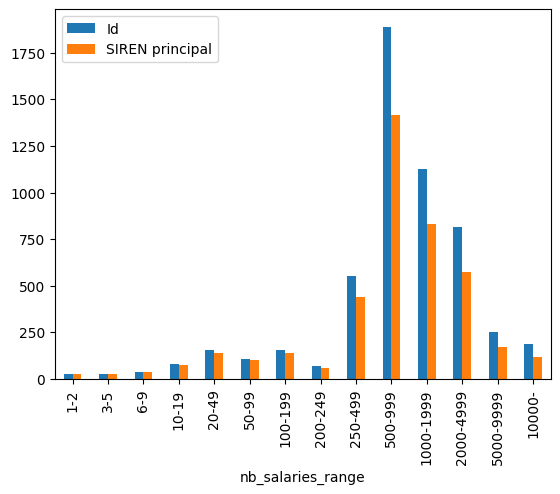

In [11]:
x = df.groupby(["nb_salaries_range", "nb_salaries_min"], as_index=False).nunique()
x = x.sort_values(by='nb_salaries_min')
x.plot(x='nb_salaries_range', y=['Id', 'SIREN principal'], kind='bar')

### Année de reporting

Il semblerait que la barre orange soit parfois un peu en dessous de la barre bleue -> il est possible que certaines entreprises fassent plusieurs submissions avec un même SIREN principal, la même année

<Axes: xlabel='Année de reporting'>

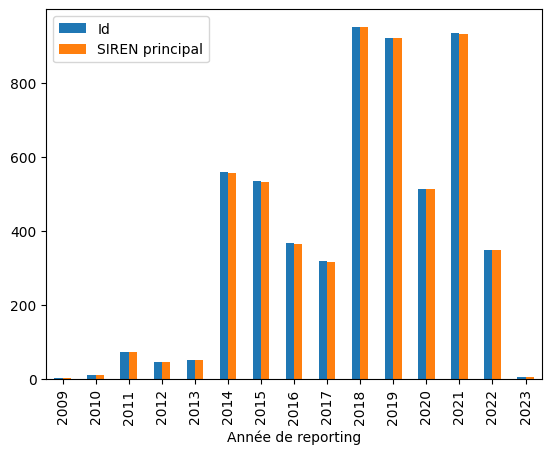

In [76]:
_plot_nunique(df, 'Année de reporting', sort=False)

### Type de structure

<Axes: xlabel='Type de structure'>

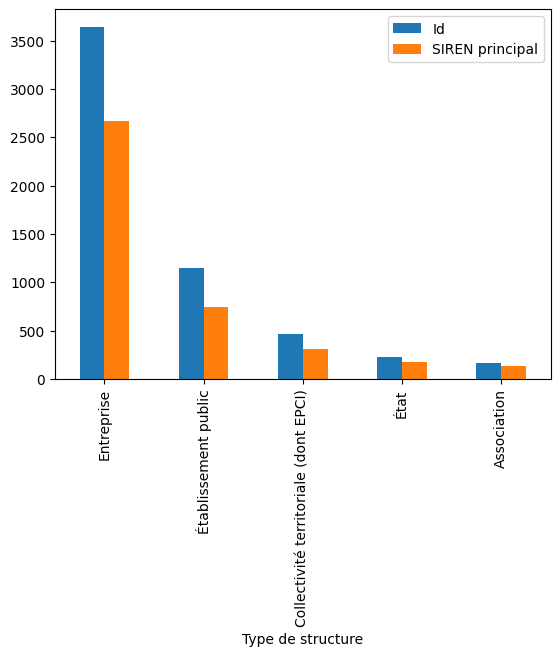

In [77]:
_plot_nunique(df, 'Type de structure')

### Mode de consolidation (opérationnel / financier)

<Axes: xlabel='Mode de consolidation'>

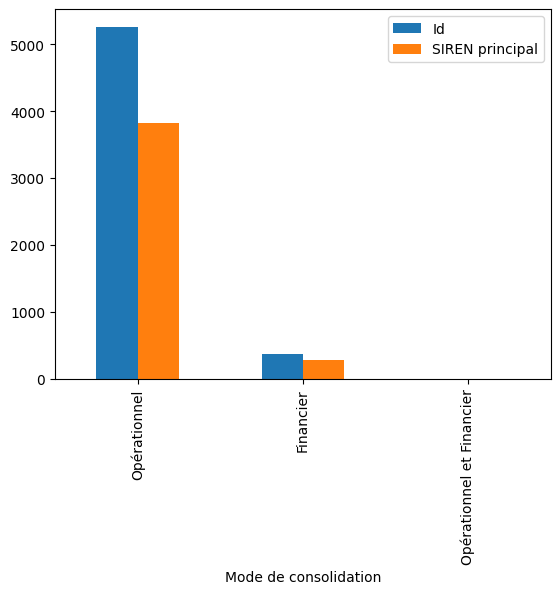

In [78]:
_plot_nunique(df, 'Mode de consolidation')

### Secteur d'activité

Autres idees de plot:
* quels secteurs sont les "meilleurs eleves"? (% d'entreprises qui repondent a la reglementation)
* plot en cercle interactif sur lequel on peut zoomer

<Axes: xlabel='naf1'>

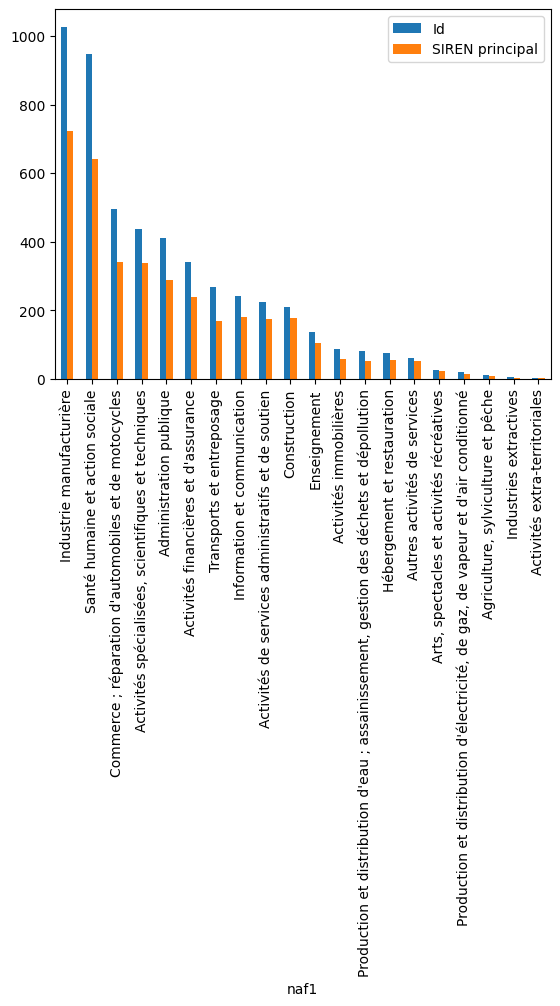

In [75]:
_plot_nunique(df, 'naf1')

<Axes: xlabel='naf2'>

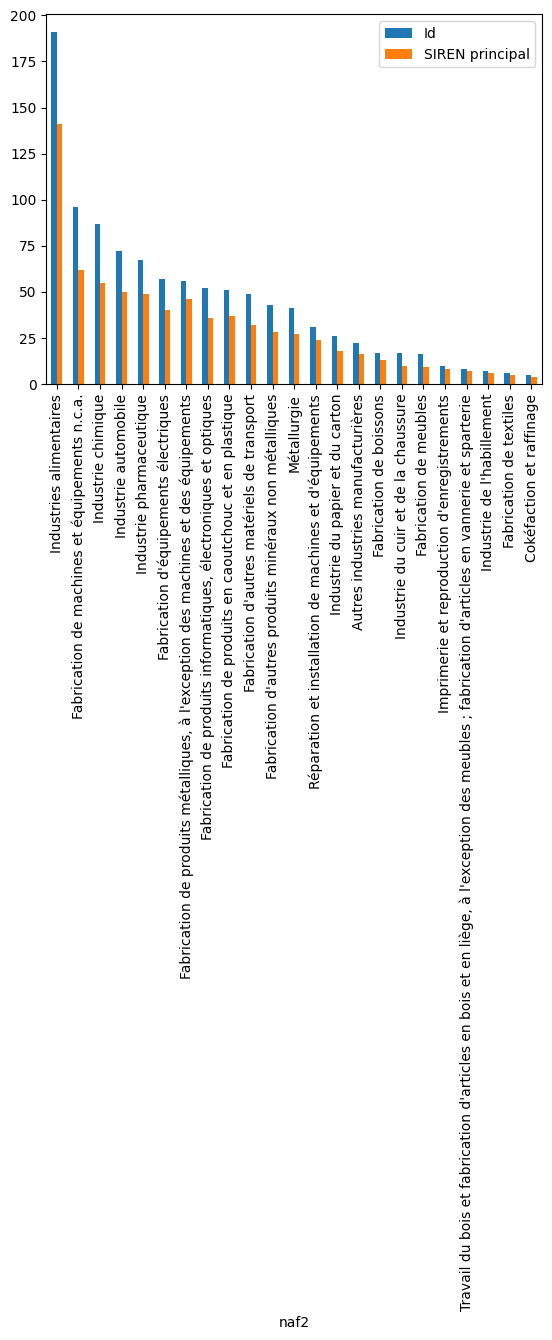

In [80]:
_plot_nunique(df[df.naf1 == 'Industrie manufacturière'], 'naf2')

## Benchmark

* indicateurs: intensite carbone / employe ou par euro
* a distinguer par secteur d'entreprise
* a distinguer par scope/type d'emissions?


## Autres idées

* study the sources used: base ADEME? other?
* postes ecartes: lesquels, quel %?
* aide diag decarbonaction
* actions envisagees par la suite + objectifs
    * evolution des objectifs dans le temps?
* study the number of beges uploaded vs what the law requires
    * quel % d'entreprises qui repondent aux obligations, par secteur
